# Pool Image Classification - Basic CNN

The goal of this notebook is to classify from satellite images whether or not a home has a pool. The creation of this notebook relied heavily on a [Keras blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) about building neural networks with a small amount of data. To start, let's import packages:

In [32]:
import os # for navigating directories
import numpy as np
from skimage import io # used to load images as numpy arrays
from sklearn.model_selection import train_test_split # split a data set into training and testing
from scipy.misc import imresize, imsave # resize images and save as pngs
import matplotlib.pyplot as plt

from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten # all the various neural network layers
from keras.utils import np_utils # utilities for one-hot encoding of ground truth value
from keras import regularizers # used to regularize the weights

Next load the data as numpy arrays of the desired size. Of the image sizes I tried, I found 30 x 30 pixels to work best. Given the small amount of data, we want to minimize the number of parameters we need to estimate. Therefore, the smaller we can have the photo (and still be able to distinguish the pool), the better. In order to be sure we aren't setting the resolution too low, the first few images in each class are displayed.

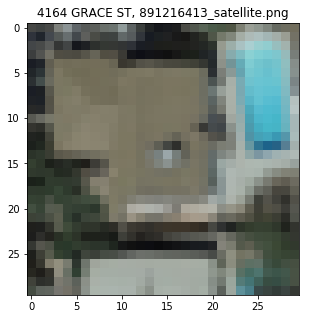

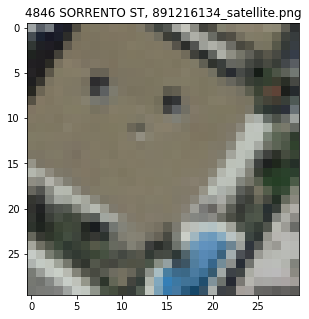

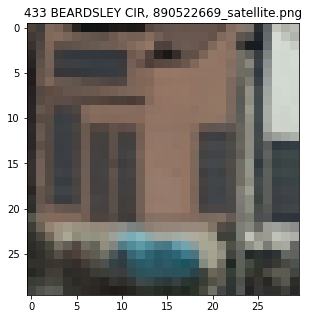

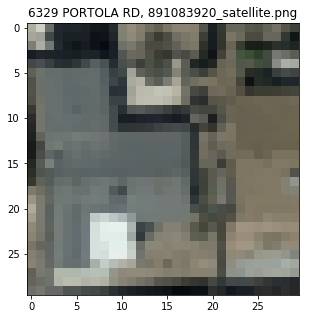

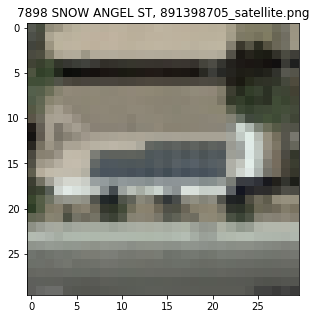

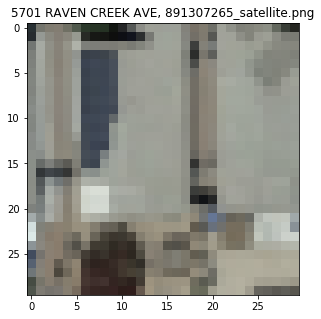

93 Pool Examples
93 No Pool Examples


In [2]:
# Start by counting the number of photos in each class
pool_count = 0
for (dirpath, dirnames, filenames) in os.walk('../data/pool/with pool'):
    for f in filenames:
        pool_count += 1

no_pool_count = 0
for (dirpath, dirnames, filenames) in os.walk('../data/pool/without pool'):
    for f in filenames:
        no_pool_count += 1
        # for now we'll ensure the same number of pool/no pool examples to avoid biasing the model
        if no_pool_count == pool_count:
            break

total_count = pool_count + no_pool_count

# desired shape of the input images
shape = (30,30,3)

# numpy arrays for storing data and labels (first dimension indexes over samples)
X = np.zeros((total_count,)+shape)
y = np.zeros((total_count,))
# because of the order we are loading them, the first ones are all pool examples
y[:pool_count] = 1

index = 0
for (dirpath, dirnames, filenames) in os.walk('../data/pool/with pool'):
    for f in filenames:
        # load the image as numpy array
        im = io.imread('../data/pool/with pool/' + f)
        # resize image to desired shape
        im_resize = imresize(im,shape)
        # store in data matrix
        X[index,:,:,:] = im_resize
        index += 1
        if index < 4:
            plt.figure(figsize=(5,5))
            plt.imshow(im_resize)
            plt.title(f)
            plt.show()

for (dirpath, dirnames, filenames) in os.walk('../data/pool/without pool'):
    for f in filenames:
        im = io.imread('../data/pool/without pool/' + f)
        im_resize = imresize(im,shape)
        X[index,:,:,:] = im_resize
        index += 1
        if index - pool_count < 4:
            plt.figure(figsize=(5,5))
            plt.imshow(im_resize)
            plt.title(f)
            plt.show()
        if index == total_count:
            break
        
print("%i Pool Examples"%pool_count)
print("%i No Pool Examples"%no_pool_count)

Now that the complete data and labels are loaded we can split them into testing and training sets, store important values, and prepare the data for use by Keras.

In [3]:
# train on 2/3 and test on 1/3 of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# store the details
num_train, height, width, depth = X_train.shape
num_test = X_test.shape[0]

# ensure input data is correct type
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')

#normalize input data
X_train /= np.max(X_train)
X_test /= np.max(X_test)

Next we specify all the parameters used to create the network. This portion needed a significant amount of parameter tuning. Most of this tuning was done by hand simply because there are too many options that automating a sweep over the whole space would have taken a long time to run. From what I've read, the relatively small amount of data creates a concern of overfitting the network. The overarching structure of the network seemed to be pretty widely used: 

$$
\texttt{input -> (conv -> conv -> pool -> drop)x2 -> hidden -> drop -> output}
$$

With that in mind, the parameters that I considered changing are:

- **batch size**: number of samples used to compute the gradient in iteration
- **num epochs**: number of times to complete entire dataset (thus $total\_iterations = num\_epochs \times \frac{num\_samples}{batch\_size}$)
- **kernel size**: size of the window that is convolved with the input
- **pool size**: size of max pooling windows at each pooling layer
- **convolutional layer depth**: number of kernels in the layer (essentially the number of filters learned) (one depth for each of the 2 sets of conv layers)
- **drop probability**: number of weights to randomly zero out in the dropout layers
- **hidden size**: number of neurons in the fully connected classification layer
- **regularization parameter**: weight for regularization on the parameters (one for convolutional layers and one for hidden layer)

In terms of batch size, kernel size, pool size, and drop probability, I essentially left these as is from what I saw online. For the rest of the parameters I started with a very small network (changing conv layer depth and hidden size) to ensure that it was not complex enough to capture the distinguishing features of the images. This behavior can be observed by the accuracy plot in the next code cell when neither the blue and orange lines show a clear upward trend, meaning that the accuracy on the training and validation sets is not improving.

In [6]:
batch_size = 10 # in each iteration, we consider 10 training examples at once
num_epochs = 200 # we iterate 200 times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 8 # we will initially have 8 kernels per conv. layer...
conv_depth_2 = 16 # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 32 # the FC layer will have 32 neurons
conv_reg = 0.002 # amount of regularization to perform in convolutional layers (l2)
hidden_reg = 0.02 # amount of regularization to perform in the hidden layer (l2)

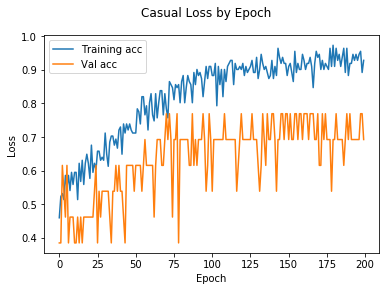

In [17]:
inp = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size),
                       kernel_regularizer=regularizers.l2(conv_reg), padding='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size),
                       kernel_regularizer=regularizers.l2(conv_reg), padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1)
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size),
                       kernel_regularizer=regularizers.l2(conv_reg), padding='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size),
                       kernel_regularizer=regularizers.l2(conv_reg), padding='same', activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2)
# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(drop_2)
hidden1 = Dense(hidden_size, activation='relu',kernel_regularizer=regularizers.l2(hidden_reg))(flat)
drop_3 = Dropout(drop_prob_2)(hidden1)
out = Dense(1, activation='sigmoid')(drop_3)

model = Model(inputs=inp, outputs=out) # To define a model, just specify its input and output layers

#sgd = SGD(lr=0.000001, momentum=0.9, decay=0.0, nesterov=False)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

fit_results = model.fit(X_train, y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=0, validation_split=0.1,class_weight={0:1,1:1}) # ...holding out 10% of the data for validation

# Plot the loss over each epoch
plt.plot(fit_results.history['acc'], label='Training acc')
plt.plot(fit_results.history['val_acc'], label='Val acc')
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.suptitle("Accuracy by Epoch")
plt.show()

In [18]:
y_hat = model.predict(X_test)
labels = (y_hat > 0.5)
y_hat = [label[0] for label in labels.astype(int)]
print(np.asarray(y_hat))
print(y_test.astype(int))
print(y_hat == y_test)
print(float(sum(y_hat == y_test))/len(y_hat))

[1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0]
[0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1]
[False  True  True  True  True False  True False  True  True  True  True
 False  True False  True  True  True False False  True False  True  True
  True  True  True  True  True  True False  True  True False  True  True
 False False  True False  True False False  True  True False  True False
  True  True  True  True  True  True  True False False  True False False
 False False]
0.629032258065


## Data Augmentation

In [19]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1,
    zoom_range=0.2,
    horizontal_flip=True)

In [20]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

augmented_data = np.zeros((0,) + shape)
augmented_labels = np.asarray([])

i = 0
for batch_data,batch_labels in datagen.flow(X_train, y_train, batch_size=10):
    augmented_data = np.vstack((augmented_data,batch_data))
    augmented_labels = np.append(augmented_labels,batch_labels)
    if i == 20:
        break
    i += 1
    
    
X_aug_train = np.vstack((X_train,augmented_data))
y_aug_train = np.append(y_train,augmented_labels)

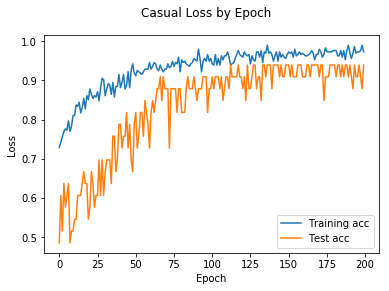

In [21]:
fit_aug_results = model.fit(X_aug_train, y_aug_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=0, validation_split=0.1) # ...holding out 10% of the data for validation

model.evaluate(X_test, y_test, verbose=0)  # Evaluate the trained model on the test set!

# Plot the loss over each epoch
plt.plot(fit_aug_results.history['acc'], label='Training acc')
plt.plot(fit_aug_results.history['val_acc'], label='Test acc')
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.suptitle("Accuracy by Epoch")
plt.show()

[1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1]
[0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True]

Accuracy: 0.951613

0.855191 - Failure


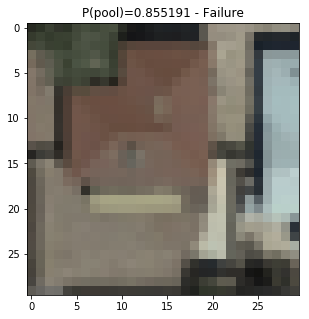

0.999916 - Success
0.022874 - Success
1.000000 - Success
0.954277 - Success
1.000000 - Success
0.107613 - Success
1.000000 - Success
0.047141 - Success
0.066417 - Success
0.008482 - Success
0.013949 - Success
0.034554 - Success
0.043048 - Success
0.045138 - Success
0.099285 - Success
0.999885 - Success
0.021142 - Success
1.000000 - Success
1.000000 - Success
0.031050 - Success
0.023717 - Success
0.067442 - Success
0.036052 - Success
0.970981 - Success
1.000000 - Success
1.000000 - Success
0.113590 - Success
1.000000 - Success
1.000000 - Success
0.999943 - Success
0.025602 - Success
0.064402 - Success
1.000000 - Success
1.000000 - Success
1.000000 - Success
0.511395 - Failure


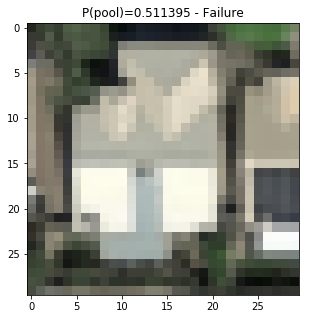

0.156740 - Success
0.064573 - Success
0.039891 - Success
0.026434 - Success
1.000000 - Success
0.999997 - Success
1.000000 - Success
1.000000 - Success
1.000000 - Success
1.000000 - Success
0.999998 - Success
0.999977 - Success
1.000000 - Success
1.000000 - Success
0.829692 - Success
1.000000 - Success
0.598632 - Success
0.091308 - Success
0.869224 - Failure


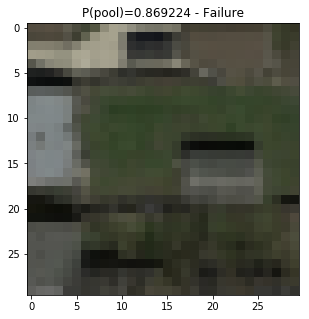

0.087405 - Success
0.026115 - Success
1.000000 - Success
0.986204 - Success
0.090237 - Success
0.999182 - Success


In [30]:
y_probs = model.predict(X_test)
labels = (y_probs > 0.5)
y_hat = [label[0] for label in labels.astype(int)]
print(np.asarray(y_hat))
print(y_test.astype(int))
print(y_hat == y_test)
print("\nAccuracy: %f\n"%(float(sum(y_hat == y_test))/len(y_hat)))

for i in range(X_test.shape[0]):
    x_i = X_test[i,:,:,:]
    y_i = model.predict(np.expand_dims(x_i,axis=0))[0]
    label_i = int(y_i>0.5)
    if label_i == y_test[i]:
        outcome = 'Success'
    else:
        outcome = 'Failure'
    print('%f - %s'%(y_i,outcome))
    if y_test[i] != label_i:
        plt.figure(figsize=(5,5))
        plt.imshow(x_i)
        plt.title('P(pool)=%f - %s'%(y_i,outcome))
        plt.show()

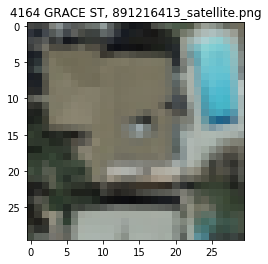

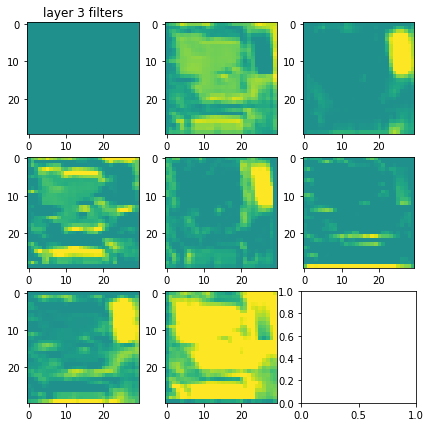

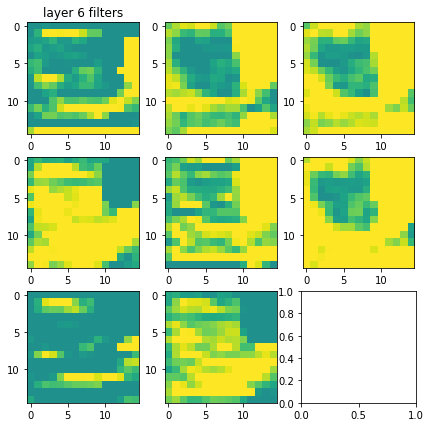

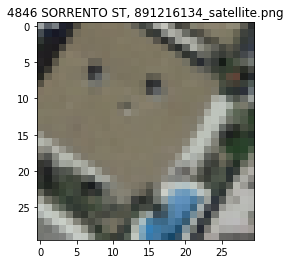

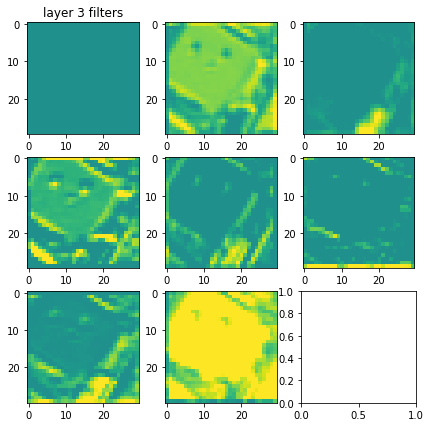

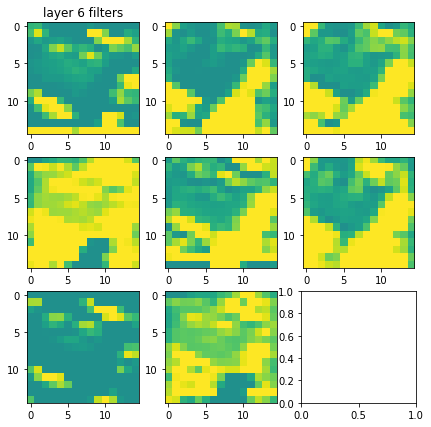

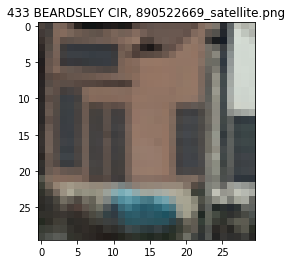

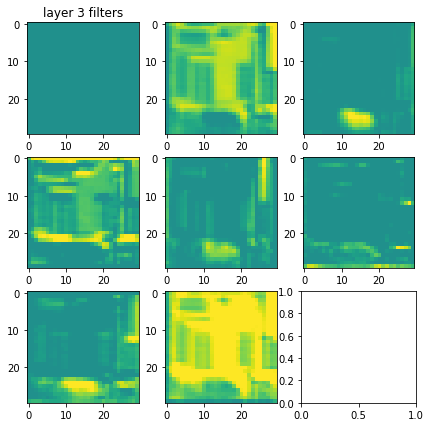

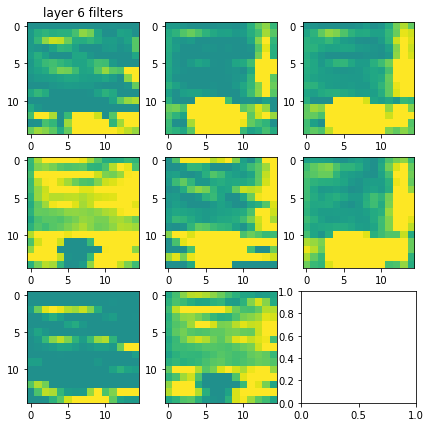

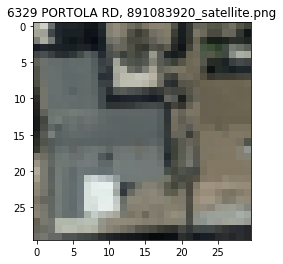

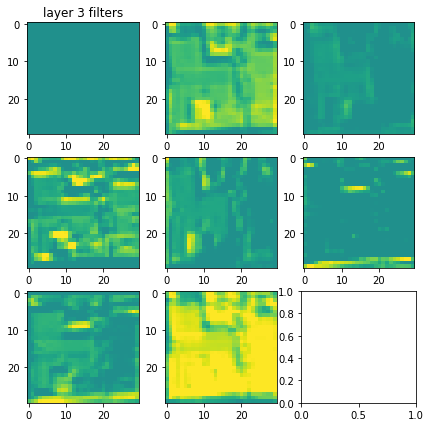

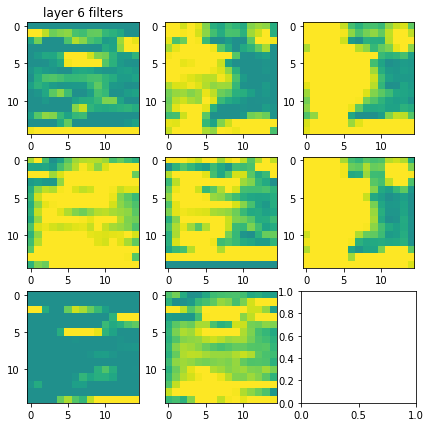

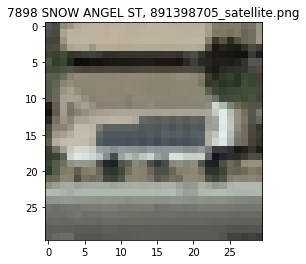

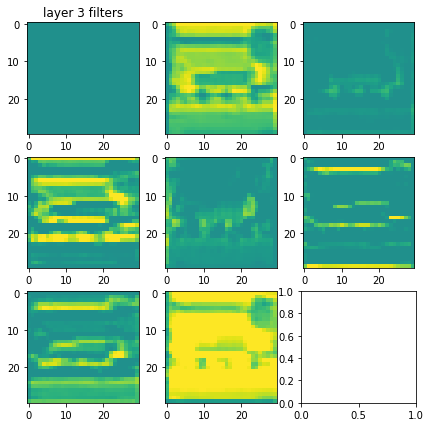

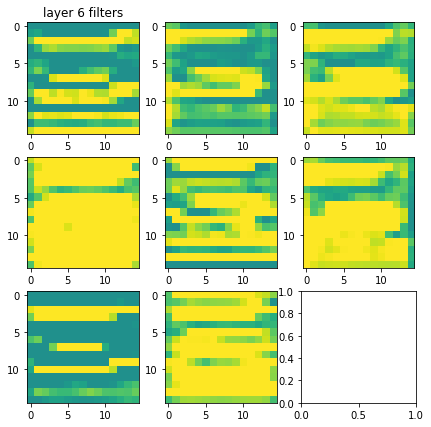

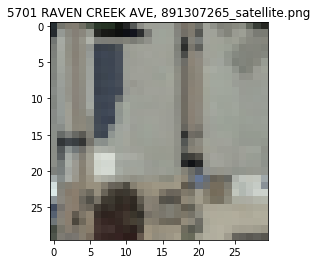

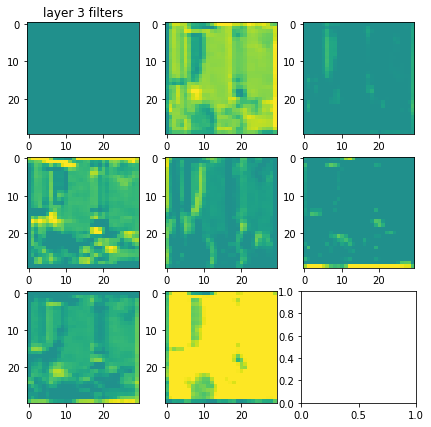

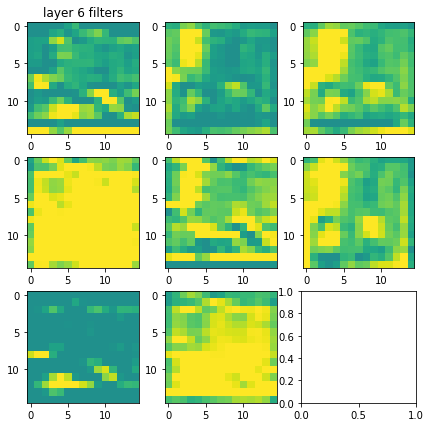

In [40]:
intermediate_layer_model1 = Model(inputs=model.input,
                                 outputs=model.layers[1].output)

intermediate_layer_model2 = Model(inputs=model.input,
                                 outputs=model.layers[5].output)

index = 0
for (dirpath, dirnames, filenames) in os.walk('../data/pool/with pool'):
    for f in filenames:
        im = io.imread('../data/pool/with pool/' + f)
        im_resize = imresize(im,shape)
        X[index,:,:,:] = im_resize
        index += 1
        if index < 4:
            
            plt.figure(figsize=(4,4))
            plt.imshow(im_resize)
            plt.title(f)
            
            out1 = intermediate_layer_model1.predict(np.expand_dims(im_resize,axis=0))   
            fig,axarr = plt.subplots(3,3,figsize=(7,7))
            axarr = axarr.reshape(-1)
            axarr[0].set_title('layer 3 filters')
            for i in range(8):
                filt = axarr[i].imshow(np.squeeze(out1,axis=0)[:,:,i])
                filt.set_clim([-100,100])
            plt.show()
            
            out2 = intermediate_layer_model2.predict(np.expand_dims(im_resize,axis=0))
            fig,axarr = plt.subplots(3,3,figsize=(7,7))
            axarr = axarr.reshape(-1)
            axarr[0].set_title('layer 6 filters')
            for i in range(8):
                filt = axarr[i].imshow(np.squeeze(out2,axis=0)[:,:,i])
                filt.set_clim([-100,100])
            plt.show()
            
        else:
            break
index = 0
for (dirpath, dirnames, filenames) in os.walk('../data/pool/without pool'):
    for f in filenames:
        im = io.imread('../data/pool/without pool/' + f)
        im_resize = imresize(im,shape)
        X[index,:,:,:] = im_resize
        index += 1
        if index < 4:
            plt.figure(figsize=(4,4))
            plt.imshow(im_resize)
            plt.title(f)
            
            out1 = intermediate_layer_model1.predict(np.expand_dims(im_resize,axis=0))   
            fig,axarr = plt.subplots(3,3,figsize=(7,7))
            axarr = axarr.reshape(-1)
            axarr[0].set_title('layer 3 filters')
            for i in range(8):
                filt = axarr[i].imshow(np.squeeze(out1,axis=0)[:,:,i])
                filt.set_clim([-100,100])
            plt.show()
            
            out2 = intermediate_layer_model2.predict(np.expand_dims(im_resize,axis=0))
            fig,axarr = plt.subplots(3,3,figsize=(7,7))
            axarr = axarr.reshape(-1)
            axarr[0].set_title('layer 6 filters')
            for i in range(8):
                filt = axarr[i].imshow(np.squeeze(out2,axis=0)[:,:,i])
                filt.set_clim([-100,100])
            plt.show()
        else:
            break
